In [4]:
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point
import requests
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from geopy.geocoders import Nominatim
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import folium
from textblob import TextBlob
from multiprocessing import Pool, cpu_count

In [5]:
# Ruta de los archivos Parquet Yeld
a1 = "parquet_yeld/Business_Category.parquet"
a2 = "parquet_yeld/Business.parquet"
a3 = "parquet_yeld/Categories.parquet"
a4 = "parquet_yeld/Tips.parquet"
a5 = "parquet_yeld/Users.parquet"
a6 = "parquet_yeld/Reviews.parquet"

In [6]:
# Leer los archivos Parquet
Business_Category = pd.read_parquet(a1)
Business = pd.read_parquet(a2)
Categories = pd.read_parquet(a3)
Tips = pd.read_parquet(a4)
Users = pd.read_parquet(a5)
Reviews = pd.read_parquet(a6)

In [7]:
# Ruta de los archivos Csv Google
b1 = "csv_google/cleaned_data (1) ESTADO DE PENNSILVANIA.csv"
b2 = "csv_google/cleaned_data (2) ESTADO DE LA FLORIDA.csv"
b3 = "csv_google/cleaned_data (3) ESTADO DE TENNESSEE.csv"
b4 = "csv_google/cleaned_data (4) ESTADO DE INDIANA.csv"
b5 = "csv_google/cleaned_data (6) ESTADO DE MISSOURI.csv"

Identificar Ubicaciones Ideales para Apertura de Locales:

Índice de Calificaciones Positivas por Ubicación:

1. Criterio: Número de reseñas con 4 o más estrellas / Número total de reseñas por ubicación
2. Fórmula: (Índice promedio actual - Índice promedio anterior) / Índice promedio anterior
3. KPI Meta: 10% o más de incremento año con año.

In [8]:
Business.head()

,business_id,name,address,latitude,longitude,stars,review_count,state
0,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,40.338183,-75.471659,4.5,13,MO
1,n_0UpQx1hsNbnPUSlodU8w,Famous Footwear,"8522 Eager Road, Dierbergs Brentwood Point",38.627695,-90.340465,2.5,13,PA
2,qkRM_2X51Yqxk3btlwAQIg,Temple Beth-El,400 Pasadena Ave S,27.766590,-82.732983,3.5,5,PA
3,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,38.565165,-90.321087,3.0,19,TN
4,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,36.208102,-86.768170,1.5,10,MO


In [9]:
Reviews.head()

,review_id,business_id,user_id,rating,text,date
0,KU_O5udG6zpxOg-VcAEodg,XQfwVwDr-v0ZS3_CbbE5Xw,mh_-eMZ6K5RLWhZyISBhwA,3,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,JrIxlS1TzJ-iCu79ul40cQ,04UD14gamNjLY0IDYVhHJg,eUta8W_HdHMXPzLBBZhL1A,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31
2,_ZeMknuYdlQcUqng_Im3yg,LHSTtnW3YHCeUkRDGyJOyw,yfFzsLmaWF2d4Sr0UNbBgg,5,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16
3,ZKvDG2sBvHVdF5oBNUOpAQ,B5XSoSG3SfvQGtKEGQ1tSQ,wSTuiTk-sKNdcFyprzZAjg,3,This easter instead of going to Lopez Lake we ...,2016-03-30 22:46:33
4,pUycOfUwM8vqX7KjRRhUEA,gebiRewfieSdtt17PTW6Zg,59MxRhNVhU9MYndMkz0wtw,3,Had a party of 6 here for hibachi. Our waitres...,2016-07-25 07:31:06


In [10]:
# Unir los dataframes en 'business_id' agregando las columnas 'state', 'latitude', 'longitude' y 'address'
Ubicacion_Reviews = pd.merge(Reviews, Business[['business_id', 'state', 'latitude', 'longitude', 'name']], on='business_id', how='left')

In [11]:
Ubicacion_Reviews.head()

,review_id,business_id,user_id,rating,text,date,state,latitude,longitude,name
0,KU_O5udG6zpxOg-VcAEodg,XQfwVwDr-v0ZS3_CbbE5Xw,mh_-eMZ6K5RLWhZyISBhwA,3,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,PA,40.210196,-75.223639,Turning Point of North Wales
1,JrIxlS1TzJ-iCu79ul40cQ,04UD14gamNjLY0IDYVhHJg,eUta8W_HdHMXPzLBBZhL1A,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31,TN,39.938013,-75.148131,Dmitri's
2,_ZeMknuYdlQcUqng_Im3yg,LHSTtnW3YHCeUkRDGyJOyw,yfFzsLmaWF2d4Sr0UNbBgg,5,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16,FL,40.407537,-75.338825,Fries Rebellion
3,ZKvDG2sBvHVdF5oBNUOpAQ,B5XSoSG3SfvQGtKEGQ1tSQ,wSTuiTk-sKNdcFyprzZAjg,3,This easter instead of going to Lopez Lake we ...,2016-03-30 22:46:33,PA,34.597239,-119.510772,Los Padres National Forest
4,pUycOfUwM8vqX7KjRRhUEA,gebiRewfieSdtt17PTW6Zg,59MxRhNVhU9MYndMkz0wtw,3,Had a party of 6 here for hibachi. Our waitres...,2016-07-25 07:31:06,FL,34.416984,-119.695556,Hibachi Steak House & Sushi Bar


In [12]:
# Asegurar que la columna 'date' esté en formato datetime
Ubicacion_Reviews['date'] = pd.to_datetime(Ubicacion_Reviews['date'])

In [13]:
Ubicacion_Reviews.head(1)

,review_id,business_id,user_id,rating,text,date,state,latitude,longitude,name
0,KU_O5udG6zpxOg-VcAEodg,XQfwVwDr-v0ZS3_CbbE5Xw,mh_-eMZ6K5RLWhZyISBhwA,3,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,PA,40.210196,-75.223639,Turning Point of North Wales


In [14]:
# Añadir una columna de año
Ubicacion_Reviews['year'] = Ubicacion_Reviews['date'].dt.year

In [15]:
# Filtrar las reseñas con 4 o más estrellas
Mejores_reviews = Ubicacion_Reviews[Ubicacion_Reviews['rating'] >= 4]

In [16]:
Mejores_reviews.head(3)

,review_id,business_id,user_id,rating,text,date,state,latitude,longitude,name,year
2,_ZeMknuYdlQcUqng_Im3yg,LHSTtnW3YHCeUkRDGyJOyw,yfFzsLmaWF2d4Sr0UNbBgg,5,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16,FL,40.407537,-75.338825,Fries Rebellion,2015
5,rGQRf8UafX7OTlMNN19I8A,uMvVYRgGNXf5boolA9HXTw,1WHRWwQmZOZDAhp2Qyny4g,5,My experience with Shalimar was nothing but wo...,2015-06-21 14:48:06,PA,27.947520,-82.527879,Shalimar Fine Jewelers,2015
6,l3Wk_mvAog6XANIuGQ9C7Q,EQ-TZ2eeD_E0BHuvoaeG5Q,ZbqSHbgCjzVAqaa7NKWn5A,4,"Locals recommended Milktooth, and it's an amaz...",2015-08-19 14:31:45,PA,39.759169,-86.146494,Milktooth,2015


In [17]:
# Contar el total de reseñas y las de 4 o más estrellas por año y estado
total_reviews_year_state = Ubicacion_Reviews.groupby(['year', 'state']).size().reset_index(name='total_reviews')
mejor_rating_reviews_por_year_state = Mejores_reviews.groupby(['year', 'state']).size().reset_index(name='high_rating_reviews')


In [18]:
# Unir los dataframes
reviews_por_year_state = pd.merge(total_reviews_year_state, mejor_rating_reviews_por_year_state, on=['year', 'state'], how='left')

In [19]:
reviews_por_year_state

,year,state,total_reviews,high_rating_reviews
0,2005,FL,158,107
1,2005,IN,56,42
2,2005,MO,51,34
3,2005,PA,188,132
4,2005,TN,66,52
...,...,...,...,...
85,2022,FL,5384,3564
86,2022,IN,2255,1481
87,2022,MO,2285,1527
88,2022,PA,7390,4844


In [20]:
# Reemplazar NaN en 'high_rating_reviews' por 0
reviews_por_year_state['high_rating_reviews'].fillna(0, inplace=True)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_16360\4114725064.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reviews_por_year_state['high_rating_reviews'].fillna(0, inplace=True)


In [21]:
# Calcular el índice promedio para cada año y estado
reviews_por_year_state['index_average'] = reviews_por_year_state['high_rating_reviews'] / reviews_por_year_state['total_reviews']

In [22]:
reviews_por_year_state

,year,state,total_reviews,high_rating_reviews,index_average
0,2005,FL,158,107,0.677215
1,2005,IN,56,42,0.750000
2,2005,MO,51,34,0.666667
3,2005,PA,188,132,0.702128
4,2005,TN,66,52,0.787879
...,...,...,...,...,...
85,2022,FL,5384,3564,0.661961
86,2022,IN,2255,1481,0.656763
87,2022,MO,2285,1527,0.668271
88,2022,PA,7390,4844,0.655480


In [23]:
# Crear un dataframe separado para calcular el incremento año con año
reviews_incremento = reviews_por_year_state.copy()

In [24]:
# Ordenar el dataframe por estado y año
reviews_incremento.sort_values(by=['state', 'year'], inplace=True)

In [25]:
# Calcular el incremento año con año
reviews_incremento['incremento_anual'] = reviews_incremento.groupby('state')['index_average'].pct_change()

In [26]:
reviews_incremento

,year,state,total_reviews,high_rating_reviews,index_average,incremento_anual
0,2005,FL,158,107,0.677215,NaN
5,2006,FL,647,462,0.714065,0.054414
10,2007,FL,2637,1782,0.675768,-0.053632
15,2008,FL,8078,5422,0.671206,-0.006751
20,2009,FL,12472,8091,0.648733,-0.033481
...,...,...,...,...,...,...
69,2018,TN,72304,48736,0.674043,0.002365
74,2019,TN,71310,47554,0.666863,-0.010652
79,2020,TN,43864,29438,0.671120,0.006383
84,2021,TN,48247,31316,0.649077,-0.032845


In [27]:
# Filtrar los datos para obtener el incremento de años recientes
reviews_incremento_reciente = reviews_incremento.dropna(subset=['incremento_anual'])

In [28]:
reviews_incremento_reciente

,year,state,total_reviews,high_rating_reviews,index_average,incremento_anual
5,2006,FL,647,462,0.714065,0.054414
10,2007,FL,2637,1782,0.675768,-0.053632
15,2008,FL,8078,5422,0.671206,-0.006751
20,2009,FL,12472,8091,0.648733,-0.033481
25,2010,FL,23644,15377,0.650355,0.002500
...,...,...,...,...,...,...
69,2018,TN,72304,48736,0.674043,0.002365
74,2019,TN,71310,47554,0.666863,-0.010652
79,2020,TN,43864,29438,0.671120,0.006383
84,2021,TN,48247,31316,0.649077,-0.032845


In [29]:
# Filtrar los datos con el incremento año con año de al menos el 10%
reviews_incremento_objetivo = reviews_incremento_reciente[reviews_incremento_reciente['incremento_anual'] >= 0.01]

In [30]:
reviews_incremento_objetivo

,year,state,total_reviews,high_rating_reviews,index_average,incremento_anual
5,2006,FL,647,462,0.714065,0.054414
40,2013,FL,67244,43807,0.651463,0.017166
45,2014,FL,92181,60920,0.660874,0.014445
55,2016,FL,132223,89078,0.673695,0.011087
75,2020,FL,95688,65535,0.684882,0.015050
46,2014,IN,36095,23911,0.662446,0.013027
51,2015,IN,47614,31886,0.669677,0.010915
61,2017,IN,57130,38909,0.681061,0.010871
76,2020,IN,39421,26654,0.676137,0.019652
7,2006,MO,262,198,0.755725,0.133588


In [31]:
Ubicacion_Reviews

,review_id,business_id,user_id,rating,text,date,state,latitude,longitude,name,year
0,KU_O5udG6zpxOg-VcAEodg,XQfwVwDr-v0ZS3_CbbE5Xw,mh_-eMZ6K5RLWhZyISBhwA,3,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,PA,40.210196,-75.223639,Turning Point of North Wales,2018
1,JrIxlS1TzJ-iCu79ul40cQ,04UD14gamNjLY0IDYVhHJg,eUta8W_HdHMXPzLBBZhL1A,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31,TN,39.938013,-75.148131,Dmitri's,2015
2,_ZeMknuYdlQcUqng_Im3yg,LHSTtnW3YHCeUkRDGyJOyw,yfFzsLmaWF2d4Sr0UNbBgg,5,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16,FL,40.407537,-75.338825,Fries Rebellion,2015
3,ZKvDG2sBvHVdF5oBNUOpAQ,B5XSoSG3SfvQGtKEGQ1tSQ,wSTuiTk-sKNdcFyprzZAjg,3,This easter instead of going to Lopez Lake we ...,2016-03-30 22:46:33,PA,34.597239,-119.510772,Los Padres National Forest,2016
4,pUycOfUwM8vqX7KjRRhUEA,gebiRewfieSdtt17PTW6Zg,59MxRhNVhU9MYndMkz0wtw,3,Had a party of 6 here for hibachi. Our waitres...,2016-07-25 07:31:06,FL,34.416984,-119.695556,Hibachi Steak House & Sushi Bar,2016
...,...,...,...,...,...,...,...,...,...,...,...
4344941,zHZ-A1qyKDEgyZMDaD--wg,6WaI-IN8ql0xpEKlb4q8tg,_XVdmFWSgTN6YlojUxixTA,5,We redesigned my moms dress and mad it complet...,2022-01-17 20:59:01,FL,39.850808,-86.139128,The House of Bretón,2022
4344942,H0RIamZu0B0Ei0P4aeh3sQ,jals67o91gcrD4DC81Vk6w,qskILQ3k0I_qcCMI-k6_QQ,5,Latest addition to services from ICCU is Apple...,2014-12-17 21:45:20,FL,43.614187,-116.197468,Idaho Central Credit Union,2014
4344943,shTPgbgdwTHSuU67mGCmZQ,2vLksaMmSEcGbjI5gywpZA,Zo0th2m8Ez4gLSbHftiQvg,5,"This spot offers a great, affordable east week...",2021-03-31 16:55:10,TN,27.671976,-82.353671,Canoe Outpost-Little Manatee River,2021
4344944,YNfNhgZlaaCO5Q_YJR4rEw,R1khUUxidqfaJmcpmGd4aw,mm6E4FbCMwJmb7kPDZ5v2Q,4,This Home Depot won me over when I needed to g...,2019-12-30 03:56:30,TN,40.163870,-75.127559,The Home Depot,2019


In [32]:
data = Ubicacion_Reviews

Preprocesamiento de los datos

In [33]:
# Eliminar columnas innecesarias
data.drop(['review_id', 'user_id', 'text', 'date'], axis=1, inplace=True)

# Eliminar filas con valores nulos
data.dropna(inplace=True)

In [34]:
data.head()

,business_id,rating,state,latitude,longitude,name,year
0,XQfwVwDr-v0ZS3_CbbE5Xw,3,PA,40.210196,-75.223639,Turning Point of North Wales,2018
1,04UD14gamNjLY0IDYVhHJg,1,TN,39.938013,-75.148131,Dmitri's,2015
2,LHSTtnW3YHCeUkRDGyJOyw,5,FL,40.407537,-75.338825,Fries Rebellion,2015
3,B5XSoSG3SfvQGtKEGQ1tSQ,3,PA,34.597239,-119.510772,Los Padres National Forest,2016
4,gebiRewfieSdtt17PTW6Zg,3,FL,34.416984,-119.695556,Hibachi Steak House & Sushi Bar,2016


Análisis exploratorio de datos

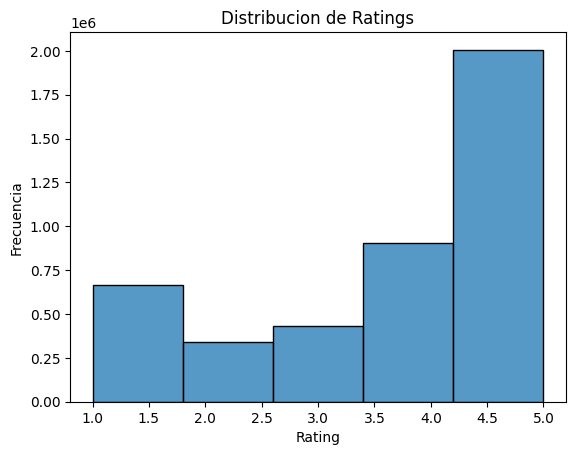

In [35]:
# Visualizar la distribución de las calificaciones
sns.histplot(data['rating'], bins=5, kde=False)
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.title('Distribucion de Ratings')
plt.show()

C:\Users\USUARIO\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


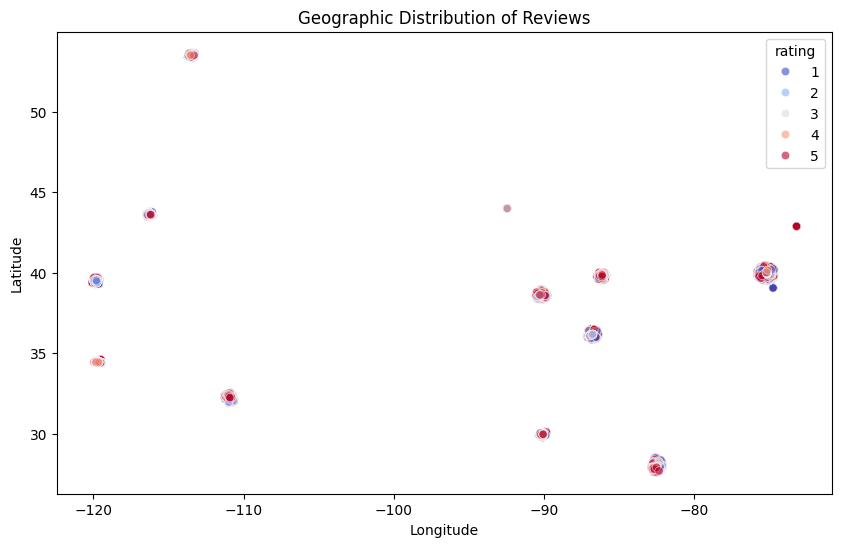

In [36]:
# Visualizar la distribución geográfica de las reseñas
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue='rating', data=data, palette='coolwarm', alpha=0.6)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Reviews')
plt.show()

In [37]:
df = Ubicacion_Reviews 

In [38]:
df.head(1)

,business_id,rating,state,latitude,longitude,name,year
0,XQfwVwDr-v0ZS3_CbbE5Xw,3,PA,40.210196,-75.223639,Turning Point of North Wales,2018


In [39]:
df.head(5)

,business_id,rating,state,latitude,longitude,name,year
0,XQfwVwDr-v0ZS3_CbbE5Xw,3,PA,40.210196,-75.223639,Turning Point of North Wales,2018
1,04UD14gamNjLY0IDYVhHJg,1,TN,39.938013,-75.148131,Dmitri's,2015
2,LHSTtnW3YHCeUkRDGyJOyw,5,FL,40.407537,-75.338825,Fries Rebellion,2015
3,B5XSoSG3SfvQGtKEGQ1tSQ,3,PA,34.597239,-119.510772,Los Padres National Forest,2016
4,gebiRewfieSdtt17PTW6Zg,3,FL,34.416984,-119.695556,Hibachi Steak House & Sushi Bar,2016


In [40]:
# Filtrar datos solo para Dunkin'
dunkin_data = df[df['name'].str.contains('Dunkin\'', case=False, regex=False)]
dunkin_data

,business_id,rating,state,latitude,longitude,name,year
1609,-3dkEoYgH8AlUtBMZvzUfg,1,PA,27.768591,-82.392793,Dunkin',2017
1757,nXJ1dAI-UGbXfeaI_b1abA,1,PA,27.733128,-82.679070,Dunkin',2017
1931,qVVz1sRZVNH2xt865M64Dg,4,TN,36.073349,-86.927093,Dunkin',2012
2086,OPhWuFj83RDS9O1qU21X8Q,2,FL,39.735884,-75.070139,Dunkin',2018
2257,Yl2iZQZ4EB7N2vnZDYqoIA,5,TN,39.877781,-75.113744,Dunkin',2016
...,...,...,...,...,...,...,...
4342864,cCLINaXaTfB1grCOBfnY1Q,3,IN,40.009595,-75.196321,Dunkin',2010
4343240,tMj79H5v1nOWmg9tsMfWiQ,3,IN,39.955320,-75.182006,Dunkin',2018
4343460,OhxH_vLWKwSohst8h0G3hA,1,FL,40.051245,-75.118084,Dunkin',2021
4343681,brlew1UwRlO6Qj9QlQ-WWQ,2,PA,40.124685,-74.962247,Dunkin',2019


In [41]:
# Preparar los datos para el modelo
X = dunkin_data[['latitude', 'longitude', 'rating', 'year']]
y = dunkin_data['rating']

In [42]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Convertir datos a formato DMatrix para XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [44]:
# Definir parámetros del modelo
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

In [45]:
# Entrenar el modelo de XGBoost
model = xgb.train(params, dtrain, num_boost_round=100)

In [46]:
# Predecir en el conjunto de prueba
y_pred = model.predict(dtest)

In [47]:
# Evaluar el modelo
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 1.3051346384574905e-05


c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [48]:
# Definir rangos para latitud y longitud
min_longitude, max_longitude = min(df['longitude']), max(df['longitude'])
min_latitude, max_latitude = min(df['latitude']), max(df['latitude'])

In [49]:
# Generar un grid de latitudes y longitudes
num_points = 20  # Número de puntos en el grid
longitude_grid = np.linspace(min_longitude, max_longitude, num_points)
latitude_grid = np.linspace(min_latitude, max_latitude, num_points)

In [50]:
# Lista para almacenar las combinaciones de latitudes y longitudes
grid_data = []

In [51]:
# Llenar la lista con las combinaciones de latitudes y longitudes del grid
for latitude in latitude_grid:
    for longitude in longitude_grid:
        grid_data.append({'latitude': latitude, 'longitude': longitude})


In [52]:
# Crear un DataFrame a partir de la lista de diccionarios
predictions_df = pd.DataFrame(grid_data)

In [53]:
predictions_df

,latitude,longitude
0,27.561646,-120.095137
1,27.561646,-117.626996
2,27.561646,-115.158855
3,27.561646,-112.690714
4,27.561646,-110.222573
...,...,...
395,53.679197,-83.073021
396,53.679197,-80.604880
397,53.679197,-78.136739
398,53.679197,-75.668598


In [54]:
# Seleccionar aleatoriamente 20 filas del DataFrame
random_indices = np.random.choice(df.index, size=20, replace=False)
random_locations = df.loc[random_indices]

# Crear un mapa centrado en las primeras coordenadas
mapa = folium.Map(location=[predictions_df['latitude'].iloc[0], predictions_df['longitude'].iloc[0]], zoom_start=4)

# Añadir marcadores para cada ubicación aleatoria
for index, row in random_locations.iterrows():
    folium.Marker([row['latitude'], row['longitude']]).add_to(mapa)

# Mostrar el mapa
mapa

In [55]:
Business_Category

,business_category_id,business_id,category_id
0,1,Pns2l4eNsfO8kk83dixA6A,971
1,2,Pns2l4eNsfO8kk83dixA6A,666
2,3,Pns2l4eNsfO8kk83dixA6A,925
3,4,Pns2l4eNsfO8kk83dixA6A,1305
4,5,Pns2l4eNsfO8kk83dixA6A,510
...,...,...,...
668587,668588,mtGm22y5c2UHNXDFAjaPNw,81
668588,668589,jV_XOycEzSlTx-65W906pg,332
668589,668590,jV_XOycEzSlTx-65W906pg,830
668590,668591,jV_XOycEzSlTx-65W906pg,591


In [56]:
Categories

,category_id,category
0,1,None
1,2,Vintage & Consignment
2,3,Sandwiches
3,4,Medical Spas
4,5,Paragliding
...,...,...
1307,1308,High Fidelity Audio Equipment
1308,1309,Used Bookstore
1309,1310,Distilleries
1310,1311,Outdoor Gear


In [57]:
# Unir los dataframes en 'business_id' agregando las columnas 'state', 'latitude', 'longitude' y 'address'
Reviews1 = pd.merge(Reviews, Business[['business_id', 'state', 'latitude', 'longitude', 'name']], on='business_id', how='left')

In [58]:
Reviews1

,review_id,business_id,user_id,rating,text,date,state,latitude,longitude,name
0,KU_O5udG6zpxOg-VcAEodg,XQfwVwDr-v0ZS3_CbbE5Xw,mh_-eMZ6K5RLWhZyISBhwA,3,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,PA,40.210196,-75.223639,Turning Point of North Wales
1,JrIxlS1TzJ-iCu79ul40cQ,04UD14gamNjLY0IDYVhHJg,eUta8W_HdHMXPzLBBZhL1A,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31,TN,39.938013,-75.148131,Dmitri's
2,_ZeMknuYdlQcUqng_Im3yg,LHSTtnW3YHCeUkRDGyJOyw,yfFzsLmaWF2d4Sr0UNbBgg,5,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16,FL,40.407537,-75.338825,Fries Rebellion
3,ZKvDG2sBvHVdF5oBNUOpAQ,B5XSoSG3SfvQGtKEGQ1tSQ,wSTuiTk-sKNdcFyprzZAjg,3,This easter instead of going to Lopez Lake we ...,2016-03-30 22:46:33,PA,34.597239,-119.510772,Los Padres National Forest
4,pUycOfUwM8vqX7KjRRhUEA,gebiRewfieSdtt17PTW6Zg,59MxRhNVhU9MYndMkz0wtw,3,Had a party of 6 here for hibachi. Our waitres...,2016-07-25 07:31:06,FL,34.416984,-119.695556,Hibachi Steak House & Sushi Bar
...,...,...,...,...,...,...,...,...,...,...
4344941,zHZ-A1qyKDEgyZMDaD--wg,6WaI-IN8ql0xpEKlb4q8tg,_XVdmFWSgTN6YlojUxixTA,5,We redesigned my moms dress and mad it complet...,2022-01-17 20:59:01,FL,39.850808,-86.139128,The House of Bretón
4344942,H0RIamZu0B0Ei0P4aeh3sQ,jals67o91gcrD4DC81Vk6w,qskILQ3k0I_qcCMI-k6_QQ,5,Latest addition to services from ICCU is Apple...,2014-12-17 21:45:20,FL,43.614187,-116.197468,Idaho Central Credit Union
4344943,shTPgbgdwTHSuU67mGCmZQ,2vLksaMmSEcGbjI5gywpZA,Zo0th2m8Ez4gLSbHftiQvg,5,"This spot offers a great, affordable east week...",2021-03-31 16:55:10,TN,27.671976,-82.353671,Canoe Outpost-Little Manatee River
4344944,YNfNhgZlaaCO5Q_YJR4rEw,R1khUUxidqfaJmcpmGd4aw,mm6E4FbCMwJmb7kPDZ5v2Q,4,This Home Depot won me over when I needed to g...,2019-12-30 03:56:30,TN,40.163870,-75.127559,The Home Depot


In [59]:
# Realizar el merge
Business_Category1 = Business_Category.merge(Categories, on='category_id', how='left')
Business_Category1

,business_category_id,business_id,category_id,category
0,1,Pns2l4eNsfO8kk83dixA6A,971,Doctors
1,2,Pns2l4eNsfO8kk83dixA6A,666,Traditional Chinese Medicine
2,3,Pns2l4eNsfO8kk83dixA6A,925,Naturopathic/Holistic
3,4,Pns2l4eNsfO8kk83dixA6A,1305,Acupuncture
4,5,Pns2l4eNsfO8kk83dixA6A,510,Health & Medical
...,...,...,...,...
668587,668588,mtGm22y5c2UHNXDFAjaPNw,81,Bikes
668588,668589,jV_XOycEzSlTx-65W906pg,332,Beauty & Spas
668589,668590,jV_XOycEzSlTx-65W906pg,830,Permanent Makeup
668590,668591,jV_XOycEzSlTx-65W906pg,591,Piercing


In [60]:
df.head(5)

,business_id,rating,state,latitude,longitude,name,year
0,XQfwVwDr-v0ZS3_CbbE5Xw,3,PA,40.210196,-75.223639,Turning Point of North Wales,2018
1,04UD14gamNjLY0IDYVhHJg,1,TN,39.938013,-75.148131,Dmitri's,2015
2,LHSTtnW3YHCeUkRDGyJOyw,5,FL,40.407537,-75.338825,Fries Rebellion,2015
3,B5XSoSG3SfvQGtKEGQ1tSQ,3,PA,34.597239,-119.510772,Los Padres National Forest,2016
4,gebiRewfieSdtt17PTW6Zg,3,FL,34.416984,-119.695556,Hibachi Steak House & Sushi Bar,2016


In [61]:
# Filtrar el DataFrame para excluir los negocios con el nombre 'Dunkin''
No_Dunkin_data = df.query('name != "Dunkin\'"')

In [62]:
No_Dunkin_data

,business_id,rating,state,latitude,longitude,name,year
0,XQfwVwDr-v0ZS3_CbbE5Xw,3,PA,40.210196,-75.223639,Turning Point of North Wales,2018
1,04UD14gamNjLY0IDYVhHJg,1,TN,39.938013,-75.148131,Dmitri's,2015
2,LHSTtnW3YHCeUkRDGyJOyw,5,FL,40.407537,-75.338825,Fries Rebellion,2015
3,B5XSoSG3SfvQGtKEGQ1tSQ,3,PA,34.597239,-119.510772,Los Padres National Forest,2016
4,gebiRewfieSdtt17PTW6Zg,3,FL,34.416984,-119.695556,Hibachi Steak House & Sushi Bar,2016
...,...,...,...,...,...,...,...
4344941,6WaI-IN8ql0xpEKlb4q8tg,5,FL,39.850808,-86.139128,The House of Bretón,2022
4344942,jals67o91gcrD4DC81Vk6w,5,FL,43.614187,-116.197468,Idaho Central Credit Union,2014
4344943,2vLksaMmSEcGbjI5gywpZA,5,TN,27.671976,-82.353671,Canoe Outpost-Little Manatee River,2021
4344944,R1khUUxidqfaJmcpmGd4aw,4,TN,40.163870,-75.127559,The Home Depot,2019


In [63]:
# Preparar los datos para el modelo
A = No_Dunkin_data[['latitude', 'longitude', 'year']]
b = No_Dunkin_data['rating']

# Dividir los datos en conjuntos de entrenamiento y prueba
A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.2, random_state=42)

# Convertir datos a formato DMatrix para XGBoost
ndtrain = xgb.DMatrix(A_train, label=b_train)
ndtest = xgb.DMatrix(A_test, label=b_test)

# Definir parámetros del modelo
params1 = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

In [64]:
# Entrenar el modelo de XGBoost
model1 = xgb.train(params1, ndtrain, num_boost_round=50)

# Predecir en el conjunto de prueba
b_pred = model1.predict(ndtest)

# Evaluar el modelo
rmse = mean_squared_error(b_test, b_pred, squared=False)
print(f'Root Mean Squared Error: {rmse}')

# Definir rangos para latitud y longitud
min_longitude, max_longitude = min(df['longitude']), max(df['longitude'])
min_latitude, max_latitude = min(df['latitude']), max(df['latitude'])

# Generar un grid de latitudes y longitudes
num_points = 20  # Número de puntos en el grid
longitude_grid = np.linspace(min_longitude, max_longitude, num_points)
latitude_grid = np.linspace(min_latitude, max_latitude, num_points)

c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Root Mean Squared Error: 1.4523546987058948


In [65]:
# Lista para almacenar las combinaciones de latitudes y longitudes
grid_data = []

# Llenar la lista con las combinaciones de latitudes y longitudes del grid
for latitude in latitude_grid:
    for longitude in longitude_grid:
        grid_data.append({'latitude': latitude, 'longitude': longitude, 'year': 2024})  # Asumimos el año actual para predicción

# Crear un DataFrame a partir de la lista de diccionarios
predictions_df = pd.DataFrame(grid_data)

# Convertir datos a formato DMatrix para predicción
grid_dmatrix = xgb.DMatrix(predictions_df[['latitude', 'longitude', 'year']])

# Predecir las calificaciones para las nuevas ubicaciones
predictions_df['pred_rating'] = model1.predict(grid_dmatrix)

# Seleccionar aleatoriamente 20 filas del DataFrame de predicción
random_indices = np.random.choice(predictions_df.index, size=20, replace=False)
random_locations = predictions_df.loc[random_indices]

In [66]:
predictions_df

,latitude,longitude,year,pred_rating
0,27.561646,-120.095137,2024,3.271374
1,27.561646,-117.626996,2024,3.278986
2,27.561646,-115.158855,2024,3.012562
3,27.561646,-112.690714,2024,3.012562
4,27.561646,-110.222573,2024,3.019896
...,...,...,...,...
395,53.679197,-83.073021,2024,3.465611
396,53.679197,-80.604880,2024,3.167846
397,53.679197,-78.136739,2024,3.167846
398,53.679197,-75.668598,2024,3.167846


In [67]:
# Crear un mapa centrado en las primeras coordenadas
mapa = folium.Map(location=[predictions_df['latitude'].iloc[0], predictions_df['longitude'].iloc[0]], zoom_start=4)

# Añadir marcadores para cada ubicación aleatoria
for index, row in random_locations.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=f"Predicted Rating: {row['pred_rating']}").add_to(mapa)

# Mostrar el mapa
mapa

In [68]:
Reviews1.head()

,review_id,business_id,user_id,rating,text,date,state,latitude,longitude,name
0,KU_O5udG6zpxOg-VcAEodg,XQfwVwDr-v0ZS3_CbbE5Xw,mh_-eMZ6K5RLWhZyISBhwA,3,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,PA,40.210196,-75.223639,Turning Point of North Wales
1,JrIxlS1TzJ-iCu79ul40cQ,04UD14gamNjLY0IDYVhHJg,eUta8W_HdHMXPzLBBZhL1A,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31,TN,39.938013,-75.148131,Dmitri's
2,_ZeMknuYdlQcUqng_Im3yg,LHSTtnW3YHCeUkRDGyJOyw,yfFzsLmaWF2d4Sr0UNbBgg,5,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16,FL,40.407537,-75.338825,Fries Rebellion
3,ZKvDG2sBvHVdF5oBNUOpAQ,B5XSoSG3SfvQGtKEGQ1tSQ,wSTuiTk-sKNdcFyprzZAjg,3,This easter instead of going to Lopez Lake we ...,2016-03-30 22:46:33,PA,34.597239,-119.510772,Los Padres National Forest
4,pUycOfUwM8vqX7KjRRhUEA,gebiRewfieSdtt17PTW6Zg,59MxRhNVhU9MYndMkz0wtw,3,Had a party of 6 here for hibachi. Our waitres...,2016-07-25 07:31:06,FL,34.416984,-119.695556,Hibachi Steak House & Sushi Bar


In [69]:
# Supongamos que tu DataFrame se llama Reviews1 y tiene una columna 'text' con los comentarios
Reviews1['sentiment'] = Reviews1['text'].apply(lambda text: TextBlob(text).sentiment.polarity)

# Clasificar el sentimiento en positivo, negativo y neutral
def classify_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

Reviews1['sentiment_label'] = Reviews1['sentiment'].apply(classify_sentiment)

# Mostrar los primeros resultados
print(Reviews1[['text', 'sentiment', 'sentiment_label']].head())

                                                text  sentiment  \
0  If you decide to eat here, just be aware it is...   0.085278   
1  I am a long term frequent customer of this est...   0.202778   
2  Amazingly amazing wings and homemade bleu chee...   0.505556   
3  This easter instead of going to Lopez Lake we ...  -0.025505   
4  Had a party of 6 here for hibachi. Our waitres...   0.186364   

  sentiment_label  
0        positive  
1        positive  
2        positive  
3        negative  
4        positive  
